In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
import pandas as pd
import pylab as plt
import pystan
import seaborn as sns
import numpy as np
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
%matplotlib inline

![](./assets/DJlogo_alpha.png?raw=true)<!-- .element height="80%" width="80%" -->

<http://www.DataJavelin.com>
## Dr Peter Hurley 

## Understanding what Stan is doing

Sampling from the Posterior using Hamiltonian Monte Carlo


### Hamiltonian physics
$$ 
H = T + V 
$$
* $T = \frac{p^2}{2m}$ kinetic energy
* $V=V(q)$ potential energy
* $H$ total energy of system (conserved)
Hamiltonian mechanics can be used to describe systems where energy changes from kinetic to potential and back again over time


### Hamiltonian Monte carlo
* Potential energy = Posterior probability distribution


### [HMC simulation](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=HamiltonianMC&target=banana)
* Doesn't get stuck as using gradient
* BUT extra variables (momentum and energy) which provide useful diagnostics
* Requires:
    * gradients: curvature of log posterior (uses autodifferentation)
    * 'mass' of particle
    * Number of leaps 
    * Size of individual leaps
   


### What gets tuned
* Number of leaps
* Size of steps

Problem: If you choose badly, you get back close to where you were i.e. inefficient

### [NUTS](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=NaiveNUTS&target=banana): No U turn sampler
* Warm up phase to work out parameters
* Runs both backwards and forwards and estimates where it is turning around
* Picks parameters that optimise this behaviour

![](./assets/HMC.png)

## Other things to think about:
* How many chains?
* How many iterations?

## When things go wrong


### Divergent transitions


* Energy hasn't been conserved
* Physics approximation no longer valid
* our samples are not properly sampling posterior

The leap frog steps are a numerical approximation, not a smooth simulation

* If they are too big or rollercoaster changes violently then the approximation will fail, energy not conserved.

**BUT**: We diagnosing it is good. Other MCMC technqiues will also fail in same circumstances but you won't know

### Example

In [24]:
V=np.random.normal(0,3,10000)
x=np.random.normal(0,np.exp(V),10000)

Text(0, 0.5, 'x')

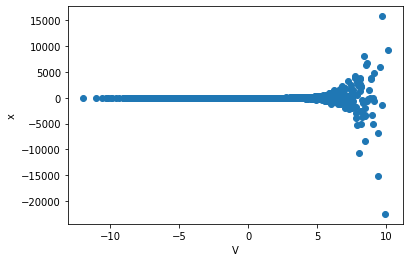

In [30]:
plt.scatter(V,x)
plt.xlabel('V')
plt.ylabel('x')

In [31]:
model="""
data{
real mu_V;
real<lower=0.0> sig_V;
real mu_x;
}
parameters {
real V;
real x;
}

model {

V~normal(mu_V,sig_V);
x~normal(0,exp(V));
}
"""

In [32]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a68d63213d4f4514b96ae981dbe942dc NOW.


In [33]:
data={
    'mu_V':0,
    'sig_V':3,
    'mu_x':0
}

In [34]:
fit=sm.sampling(data=data)

In [37]:
fit

Inference for Stan model: anon_model_a68d63213d4f4514b96ae981dbe942dc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
V      2.67     0.8   1.93  -0.13   1.05   2.57   4.06   6.65      6   1.37
x     11.01   10.06 168.95 -205.5  -8.13   0.08   6.29 413.37    282   1.01
lp__  -3.65    1.05   2.76  -9.61  -5.55  -3.39  -1.45   0.11      7   1.32

Samples were drawn using NUTS at Wed Jul 29 15:42:47 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [36]:
pystan.diagnostics.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': False,
 'divergence': False,
 'treedepth': True,
 'energy': True}

Text(0, 0.5, 'x')

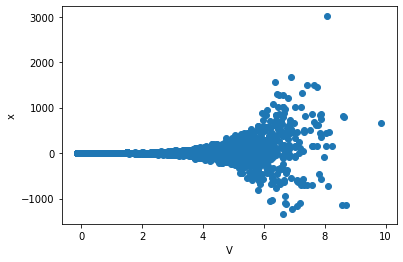

In [39]:
plt.scatter(fit['V'],fit['x'])
plt.xlabel('V')
plt.ylabel('x')

### Investigating where the divergent transitions are occuring

In [40]:
samp_params=fit.get_sampler_params(inc_warmup=False)

In [53]:
samp_params[0].keys()

odict_keys(['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'])

In [47]:
div=np.concatenate([samp_params[i]['divergent__'] for i in range(0,len(samp_params))])


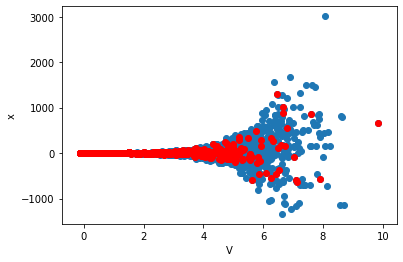

In [51]:
plt.scatter(fit['V'],fit['x'])
plt.xlabel('V')
plt.ylabel('x')


plt.scatter(fit['V'][div.astype(bool)],fit['x'][div.astype(bool)],c='r')


### How to solve: Increase `adapt delta`

In [79]:
fit=sm.sampling(data=data,control=dict(adapt_delta=0.9))

### How to solve: Non-centred parameterisation

This is our problem:
$$
V \sim Normal(0,3)
$$
$$
x \sim Normal(0,V)
$$

**Exercise**:

Think about other ways of expressing/rearranging parameters in a Normal distribution:
$$ 
\alpha \sim Normal(\mu, \sigma)
$$

$$ 
\alpha = \mu + \beta
$$
$$
\beta \sim Normal(0,sigma)
$$

$$ \alpha = \mu + z\sigma$$
$$z \sim Normal(0,1)$$
This is what we call a non-centred parameterisation

Our model becomes:
$$ V \sim Normal(0,3) $$
$$ z \sim Normal(0,1) $$
$$x=z\exp(V)$$

**Exercise**: Write this new model in Stan and sample from it

In [63]:
model="""
data{
real mu_V;
real<lower=0.0> sig_V;
real mu_x;
}
parameters {
real V;
real z;
}

transformed parameters {
real x;
x=mu_x+z*exp(V);
} 
model {
V~normal(mu_V,sig_V);
z~normal(0,1);
}
"""

In [64]:
nc_sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4cbc3ac36f3a1d110fc091be8c133d93 NOW.


In [67]:
nc_fit=nc_sm.sampling(data=data)

In [68]:
nc_fit

Inference for Stan model: anon_model_4cbc3ac36f3a1d110fc091be8c133d93.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
V     -0.04    0.05   3.04  -6.13  -2.06  -0.01   1.95   5.98   3653    1.0
z    2.6e-3    0.02   0.99  -1.86  -0.69 9.0e-3    0.7   1.93   3781    1.0
x     -1.55   12.53 778.19 -100.9  -0.57 7.9e-5   0.52  98.98   3856    1.0
lp__  -1.01    0.02   0.99  -3.73   -1.4  -0.72   -0.3  -0.02   1942    1.0

Samples were drawn using NUTS at Wed Jul 29 16:12:48 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [71]:
pystan.diagnostics.check_hmc_diagnostics(nc_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

### Why does this work
Think about the parameters Stan is actually sampling (walking around)

Text(0, 0.5, 'z')

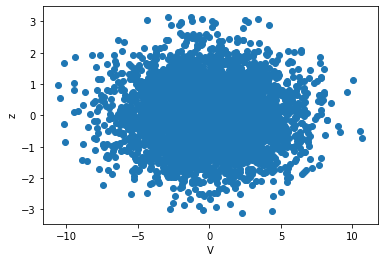

In [77]:
plt.scatter(nc_fit['V'],nc_fit['z'])
plt.xlabel('V')
plt.ylabel('z')

Text(0, 0.5, 'x')

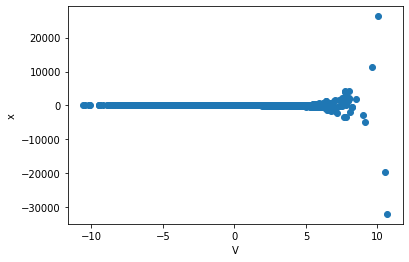

In [74]:
plt.scatter(nc_fit['V'],nc_fit['x'])
plt.xlabel('V')
plt.ylabel('x')

This trick is particularly useful when dealing with hierarchical models

### Maximum Tree Depth
When deciding how 